## Threholds Optimization and Business Costs

In [75]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Business costs
COST_FN = 100 # lost customer
COST_FP = 10 # unnecessary contact

# 1. Load Data
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
# 2. Features Selection
selected_features = ['Contract', 'tenure', 'MonthlyCharges', 'TechSupport']
X = df[selected_features]
y = df['Churn'].map({'Yes':1, 'No':0})

# 3. One-hot Encoding
X_encoded = pd.get_dummies(
    X,
    drop_first=True
)

# 4. Train final Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_encoded, y)

,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
# 5. Train Test split 

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. Predict churn probabilities for all customers

churn_probabilities = rf_model.predict_proba(X_encoded)[:,1]


### 1. Evaluate a Decision Threshold (Baseline = 0.5)

#### Apply a manual threshold (concept)

Goal: Convert probabilities into decisions. Logic:

- If probability >= 0.5 -> predict churn (1)
- Else -> no churn (0)


In [40]:
y_proba = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_05 = (y_proba >= threshold).astype(int)


#### Compute the confusion matrix

In [58]:
cm = confusion_matrix(y_test, y_pred_05)
cm

# Extract FP und FN
TN, FP, FN, TP = cm.ravel()
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)

False Positives (FP): 241
False Negatives (FN): 56


#### Compute business cost

In [57]:
business_cost_05 = FN * COST_FN + FP * COST_FP 
print(f'Total business cost at threshod 0.5: {business_cost_05}')

Total business cost at threshod 0.5: 8010


### 2. Evalute a Decision Threshold (Baseline = [0.05 - 0.95])

In [83]:
threholds = np.arange(0.05, 0.95, 0.05)

results = []

for threhold in threholds:
    # Apply threshold
    y_pred = (y_proba >= threhold).astype(int)

    # Confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    # Business costs
    business_costs = FP * COST_FP + FN * COST_FN

    # Store results
    results.append(
        {
            'Threshold':threhold,
            'FP':FP,
            'FN':FN,
            'business_cost':business_costs
        }
    )

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='business_cost')
results_df


,Threshold,FP,FN,business_cost
4,0.25,476,1,4860
5,0.30,431,9,5210
3,0.20,523,1,5330
6,0.35,381,20,5810
2,0.15,598,0,5980
1,0.10,664,0,6640
7,0.40,331,34,6710
0,0.05,742,0,7420
8,0.45,280,48,7600
9,0.50,241,56,8010


#### Visualization

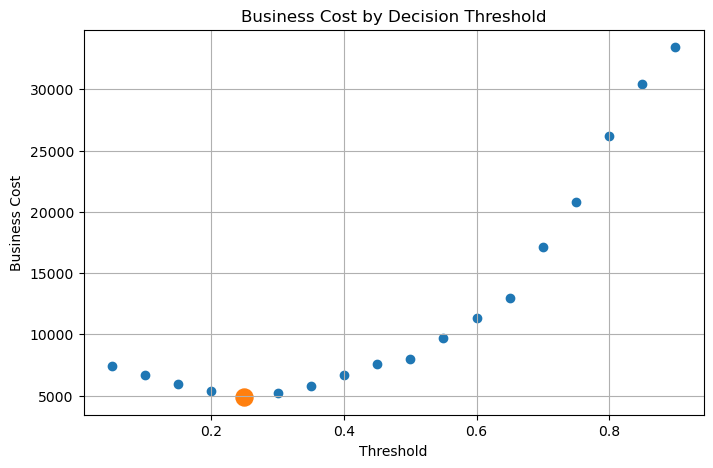

In [98]:
plot_df = results_df.sort_values("Threshold")
best = plot_df.loc[plot_df["business_cost"].idxmin()]

plt.figure(figsize=(8, 5))
plt.scatter(plot_df["Threshold"], plot_df["business_cost"])
plt.scatter(best["Threshold"], best["business_cost"], s=150)
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost by Decision Threshold")
plt.grid(True)
plt.show()

### Conclusion

By lowering the decision threshold from 0.5 to 0.25, the model significantly reduces the number of missed churners. Although this results in a higher number of customers being contacted unnecessarily, the overall business cost is reduced by approximately 39%. This demonstrates that adjusting the decision threshold can have a greater impact on business outcomes than changing the underlying model.

The selected threshold of 0.25 reflects a more aggressive retention strategy, which is appropriate in this context given that losing a customer is substantially more expensive than contacting one who would not have churned. This threshold prioritizes recall over precision, ensuring that the vast majority of at-risk customers are identified.

Overall, this analysis highlights the importance of aligning machine learning decisions with business objectives. Rather than relying on default classification thresholds, incorporating business costs into the decision process allows the model to be used as a practical and cost-effective tool for customer retention.
